In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exchange = ccxt.binance({
    'options': {
        'defaultType': 'future'
    }
})

In [3]:
symbol = 'BTC/USDT'
timeframe = '15m'
limit = 500  # number of candles to fetch

In [4]:
bars = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
data = pd.DataFrame(bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)

In [5]:
k_period = 14
d_period = 3
data['low_min'] = data['low'].rolling(window=k_period).min()
data['high_max'] = data['high'].rolling(window=k_period).max()
data['%K'] = 100 * (data['close'] - data['low_min']) / (data['high_max'] - data['low_min'])
data['%D'] = data['%K'].rolling(window=d_period).mean()

In [6]:
data['signal'] = 0  # 1 for buy, -1 for sell, 0 for no action

for i in range(1, len(data)):
    # Bullish crossover in oversold area: previous %K < %D and current %K > %D, with current %K < 20
    if (data.iloc[i-1]['%K'] < data.iloc[i-1]['%D']) and (data.iloc[i]['%K'] > data.iloc[i]['%D']) and (data.iloc[i]['%K'] < 20):
        data.iloc[i, data.columns.get_loc('signal')] = 1
    # Bearish crossover in overbought area: previous %K > %D and current %K < %D, with current %K > 80
    elif (data.iloc[i-1]['%K'] > data.iloc[i-1]['%D']) and (data.iloc[i]['%K'] < data.iloc[i]['%D']) and (data.iloc[i]['%K'] > 80):
        data.iloc[i, data.columns.get_loc('signal')] = -1

In [7]:
data['position'] = 0
current_position = 0  # 1 for long, -1 for short, 0 for no position
entry_price = 0
trade_returns = []

for i in range(1, len(data)):
    # When a buy signal occurs and we're not already long:
    if data.iloc[i]['signal'] == 1 and current_position <= 0:
        # If currently short, close short position first
        if current_position < 0:
            ret = (entry_price - data.iloc[i]['open']) / entry_price
            trade_returns.append(ret)
        current_position = 1
        entry_price = data.iloc[i]['open']
        data.iloc[i, data.columns.get_loc('position')] = 1
    # When a sell signal occurs and we're not already short:
    elif data.iloc[i]['signal'] == -1 and current_position >= 0:
        if current_position > 0:
            ret = (data.iloc[i]['open'] - entry_price) / entry_price
            trade_returns.append(ret)
        current_position = -1
        entry_price = data.iloc[i]['open']
        data.iloc[i, data.columns.get_loc('position')] = -1
    else:
        data.iloc[i, data.columns.get_loc('position')] = current_position

In [8]:
cumulative_return = np.prod([1 + r for r in trade_returns]) - 1
print("Cumulative Return: {:.2%}".format(cumulative_return))

Cumulative Return: -1.76%


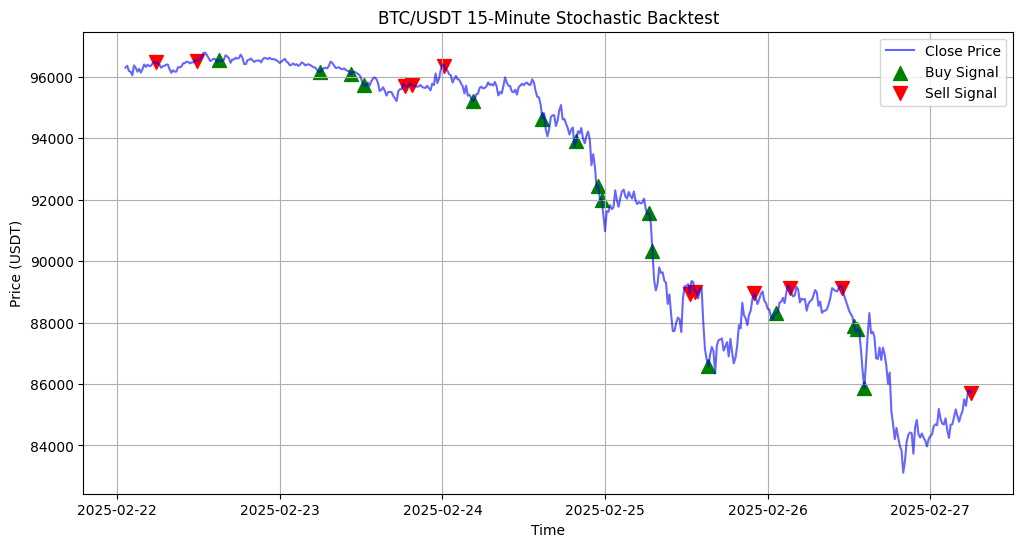

In [9]:
# --- 5. Plotting the Results ---
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Close Price', color='blue', alpha=0.6)

# Plot buy/sell signals on the price chart
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', s=100, label='Buy Signal')
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', s=100, label='Sell Signal')

plt.title(f"{symbol} 15-Minute Stochastic Backtest")
plt.xlabel("Time")
plt.ylabel("Price (USDT)")
plt.legend()
plt.grid(True)
plt.show()